<a href="https://www.kaggle.com/code/fellahabdelnour13/getting-started-with-cgans?scriptVersionId=198130534" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div id="necessary_packages" >
    <h1 style="font-family:verdana;"> Overview </h1>
</div>

<ol style="font-family:verdana;font-size:1.125rem;" >
    <li>
        <a href="#necessary_packages" >Necessary Packages</a>
    </li>
    <li>
        <a href="#utils" >Utils</a>
    </li>
    <li>
        <a href="#constants" >Constants</a>
    </li>
    <li>
        <a href="#reproducibility" >Reproducibility</a>
    </li>
    <li>
        <a href="#visualization" >Visualization</a>
    </li>
    <li>
        <a href="#dataset" >Dataset</a>
    </li>
    <li>
        <a href="#modeling" >Modeling</a>
    </li>
    <li>
        <a href="#training" >Training</a>
    </li>
    <li>
        <a href="#evaluation" >Evaluation</a>
    </li>
    <li>
        <a href="#gfd" >Generate fake data</a>
    </li>
    <li>
        <a href="#thank_you" >Thank you :)</a>
    </li>
</ol>

<div id="necessary_packages" >
    <h1 style="font-family:verdana;"> Necessary Packages </h1>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import warnings
import random
import imageio
import torch.nn.functional as F
from torch import nn,optim,Tensor
from torch.utils.data import DataLoader, Dataset
from typing import Callable,Optional
from torchinfo import summary
from tqdm.notebook import tqdm
from torchvision import transforms as T
from IPython.display import Image

In [2]:
sns.set_theme(style="whitegrid", palette="husl")

In [3]:
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

<div id="utils" >
    <h1 style="font-family:verdana;"> Utils </h1>
</div>

In [4]:
def seed_everything(seed) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
def display_images(
    images : list[np.ndarray],
    labels : list,
    nrows : int,
    ncols : int,
) -> None:
    
    fig,ax = plt.subplots(nrows,ncols,figsize=(ncols*3,nrows*3))

    k = 0

    for i in range(nrows):
        for j in range(ncols):

            ax[i,j].imshow(images[k],cmap="gray")
            ax[i,j].set_title(labels[i*ncols+j])
            ax[i,j].axis("off")

            k += 1

<div id="constants" >
    <h1 style="font-family:verdana;"> Constants </h1>
</div>

In [6]:
DATA_DIR = '/kaggle/input/fashionmnist'
TRAIN_PATH = os.path.join(DATA_DIR,'fashion-mnist_train.csv')
TEST_PATH = os.path.join(DATA_DIR,'fashion-mnist_test.csv')

In [7]:
classes = np.array([
 'T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot'
])

In [8]:
class G:

    ### Reproducibility
    seed : int = 42

    ### Device
    device : str = "cuda" if torch.cuda.is_available() else "cpu"

    ### Training
    batch_size : int = 64
    lr : float = 1e-4
    epochs : int = 30

    ### Data
    num_workers : int = 4
    prefetch_factor : int = 2

    ### Model
    latent_dim : int = 128
    num_classes : int = 10
    feature_map_size : int = 64
    channels : int = 1

<div id="reproducibility" >
    <h1 style="font-family:verdana;"> Reproducibility </h1>
</div>

In [9]:
seed_everything(G.seed)

<div id="visualization" >
    <h1 style="font-family:verdana;"> Visualization </h1>
</div>

In [10]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

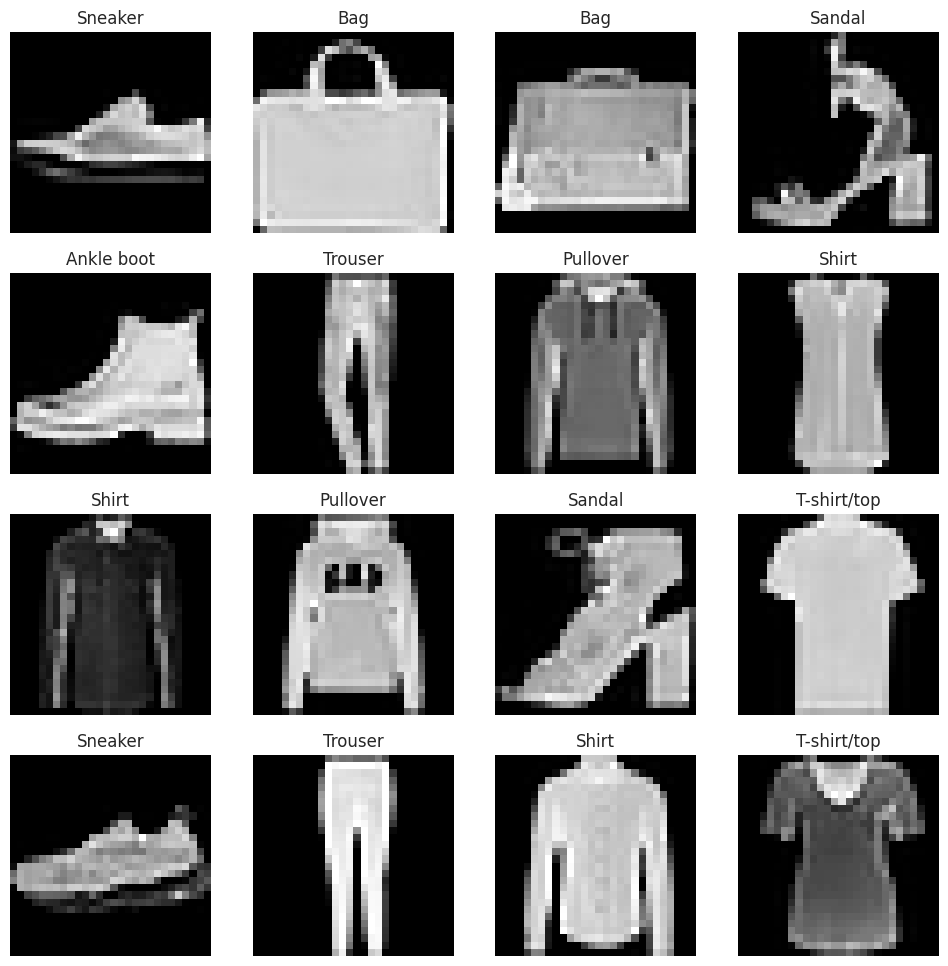

In [11]:
N_ROWS,N_COLS = 4,4
samples = train_df.sample(N_ROWS*N_COLS)
images = samples.drop('label',axis=1).values.reshape(-1,28,28)
labels = classes[samples['label'].values]
display_images(images, labels, N_ROWS, N_COLS)

<div id="dataset" >
    <h1 style="font-family:verdana;"> Dataset </h1>
</div>

In [12]:
class DataFrameDataset(Dataset):

    def __init__(
        self,
        dataframe : pd.DataFrame | str,
        target_col : str,
        transform : Optional[Callable] = None,
    ) -> None:
        
        super(DataFrameDataset,self).__init__()

        self.df = pd.read_csv(dataframe) if isinstance(dataframe,str) else dataframe
        self.transform = transform
        self.target_col = target_col

    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self,idx : int) -> dict:

        row = self.df.iloc[idx]

        image = row.drop(self.target_col).values.astype(np.uint8).reshape(28,28,1)
        label = row[self.target_col]

        if self.transform:
            image = self.transform(image)

        return {
            "id" : idx,
            "image" : image,
            "label" : label
        }
        

<div id="modeling" >
    <h1 style="font-family:verdana;"> Modeling </h1>
</div>

In [13]:
class Generator(nn.Module):

    def __init__(self,
        input_dim : int,
        output_channels : int,
        feature_map_size : int,
        num_classes : int,
    ) -> None:

        super(Generator, self).__init__()

        self.input_dim = input_dim
        self.output_channels = output_channels
        self.feature_map_size = feature_map_size
        self.num_classes = num_classes

        self.class_embedding = nn.Embedding(num_classes, num_classes)

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(input_dim + num_classes, feature_map_size * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 2,feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 1),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size, output_channels, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, labels : Tensor) -> Tensor:

        x = torch.randn(labels.size(0), self.input_dim, 1, 1, device=labels.device)
        labels = self.class_embedding(labels).reshape(-1, self.num_classes, 1, 1)
        x = torch.cat((x, labels), dim=1)

        return self.layers(x)

In [14]:
summary(
    model=Generator(64,1,64,10),
    input_data=torch.zeros(16,).long(),
    device="cpu"
)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [16, 1, 32, 32]           --
├─Embedding: 1-1                         [16, 10]                  100
├─Sequential: 1-2                        [16, 1, 32, 32]           --
│    └─ConvTranspose2d: 2-1              [16, 256, 4, 4]           303,104
│    └─BatchNorm2d: 2-2                  [16, 256, 4, 4]           512
│    └─ReLU: 2-3                         [16, 256, 4, 4]           --
│    └─ConvTranspose2d: 2-4              [16, 128, 8, 8]           524,288
│    └─BatchNorm2d: 2-5                  [16, 128, 8, 8]           256
│    └─ReLU: 2-6                         [16, 128, 8, 8]           --
│    └─ConvTranspose2d: 2-7              [16, 64, 16, 16]          131,072
│    └─BatchNorm2d: 2-8                  [16, 64, 16, 16]          128
│    └─ReLU: 2-9                         [16, 64, 16, 16]          --
│    └─ConvTranspose2d: 2-10             [16, 1, 32, 32]          

In [15]:
class Discriminator(nn.Module):

    def __init__(self, 
        input_channels : int, 
        feature_map_size : int,
        num_classes : int,
    ) -> None:

        super(Discriminator, self).__init__()

        self.input_channels = input_channels
        self.feature_map_size = feature_map_size
        self.num_classes = num_classes

        self.class_embedding = nn.Embedding(num_classes, num_classes)

        self.layers = nn.Sequential(

            nn.Conv2d(input_channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size * 4, 1, 4, 2, 1, bias=False),
        )

    def forward(self, images : Tensor,labels : Tensor) -> Tensor:

        labels = self.class_embedding(labels).reshape(-1,1,self.num_classes, 1)
        labels = labels.repeat(1,1,1,images.size(3))

        images = torch.cat((images, labels), dim=2)

        return self.layers(images)

In [16]:
summary(
    Discriminator(1,32,10),
    input_data={
        "images" : torch.randn(16,1,32,32),
        "labels" : torch.randint(0,10,(16,))
    },
    device="cpu"
)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [16, 1, 2, 2]             --
├─Embedding: 1-1                         [16, 10]                  100
├─Sequential: 1-2                        [16, 1, 2, 2]             --
│    └─Conv2d: 2-1                       [16, 32, 21, 16]          512
│    └─LeakyReLU: 2-2                    [16, 32, 21, 16]          --
│    └─Conv2d: 2-3                       [16, 64, 10, 8]           32,768
│    └─BatchNorm2d: 2-4                  [16, 64, 10, 8]           128
│    └─LeakyReLU: 2-5                    [16, 64, 10, 8]           --
│    └─Conv2d: 2-6                       [16, 128, 5, 4]           131,072
│    └─BatchNorm2d: 2-7                  [16, 128, 5, 4]           256
│    └─LeakyReLU: 2-8                    [16, 128, 5, 4]           --
│    └─Conv2d: 2-9                       [16, 1, 2, 2]             2,048
Total params: 166,884
Trainable params: 166,884
Non-trainable params:

<div id="training" >
    <h1 style="font-family:verdana;"> Training </h1>
</div>

In [17]:
transform = T.Compose([
    T.ToTensor(),
    T.Pad(2,padding_mode="constant",fill=0)
])

In [18]:
train_dataset = DataFrameDataset(train_df,'label',transform=transform)
test_dataset = DataFrameDataset(test_df,'label',transform=transform)

In [19]:
train_loader = DataLoader(train_dataset,batch_size=G.batch_size,shuffle=True,drop_last=True,num_workers=G.num_workers,prefetch_factor=G.prefetch_factor)
test_loader = DataLoader(test_dataset,batch_size=G.batch_size,shuffle=False,drop_last=False,num_workers=G.num_workers,prefetch_factor=G.prefetch_factor)

In [20]:
generator = Generator(G.latent_dim,G.channels,G.feature_map_size,G.num_classes).to(G.device)
discriminator = Discriminator(G.channels,G.feature_map_size,G.num_classes).to(G.device)

In [21]:
g_optimizer = optim.AdamW(generator.parameters(),lr=G.lr,betas=(0.5,0.999))
d_optimizer = optim.AdamW(discriminator.parameters(),lr=G.lr,betas=(0.5,0.999))

In [22]:
loss_fn = nn.BCEWithLogitsLoss()

In [23]:
def train(
    generator : nn.Module,
    discriminator : nn.Module,
    loss_fn : nn.Module,
    g_optimizer : optim.Optimizer,
    d_optimizer : optim.Optimizer,
    train_loader : DataLoader,
    test_loader : DataLoader,
    epochs : int,
    device : str,
    save_images_every : int = 100
) -> tuple[pd.DataFrame,list[Tensor]]:
    
    # Initialize history

    history = {
        "epoch" : [],
        "iteration" : [],
        "g_loss" : [],
        "d_loss" : [],
    }
    
    # Move to device
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    iterations_count = len(train_loader)
    
    images_history = []
    
    for epoch in range(epochs):

        for i,batch in tqdm(enumerate(train_loader),desc=f"Epoch {epoch+1}/{epochs}",total=len(train_loader)):
            
            ### Move to device
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            ##############################
            ### Train Discriminator
            ##############################

            ### *** Phase 1 : Train on Real Data *** ###

            # Zero the gradients
            discriminator.zero_grad()

            # Forward pass
            output = discriminator(images,labels)

            # Compute loss
            d_real_loss = loss_fn(output,torch.ones_like(output))

            # Backward pass
            d_real_loss.backward()

            ### *** Phase 2 : Train on Fake Data *** ###

            # Generate fake images
            fake_images = generator(labels)

            # Forward pass
            output = discriminator(fake_images.detach(),labels)

            # Compute loss
            d_fake_loss = loss_fn(output,torch.zeros_like(output))

            # Backward pass
            d_fake_loss.backward()

            # Update weights
            d_optimizer.step()

            ##############################
            ### Train Generator
            ##############################

            # Zero the gradients
            generator.zero_grad()

            # Forward pass
            output = discriminator(fake_images,labels)

            # Compute loss
            g_loss = loss_fn(output,torch.ones_like(output))

            # Backward pass
            g_loss.backward()

            # Update weights
            g_optimizer.step()

            ##############################
            ### Update history
            ##############################

            history["epoch"].append(epoch)
            history["iteration"].append(iterations_count)
            history["g_loss"].append(g_loss.item())
            history["d_loss"].append((d_real_loss.item() + d_fake_loss.item()) / 2)
            
            # Update iteration count
            iterations_count += 1
           
            # Save fake images
            if i % save_images_every == 0:
                images_history.append(fake_images.detach().cpu().squeeze())

    history = pd.DataFrame(history)

    return history,images_history

In [24]:
history,images = train(
    generator,
    discriminator,
    loss_fn,
    g_optimizer,
    d_optimizer,
    train_loader,
    test_loader,
    epochs=G.epochs,
    device=G.device
)

Epoch 1/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/937 [00:00<?, ?it/s]

<div id="evaluation" >
    <h1 style="font-family:verdana;"> Evaluation </h1>
</div>

<Axes: xlabel='iteration', ylabel='g_loss'>

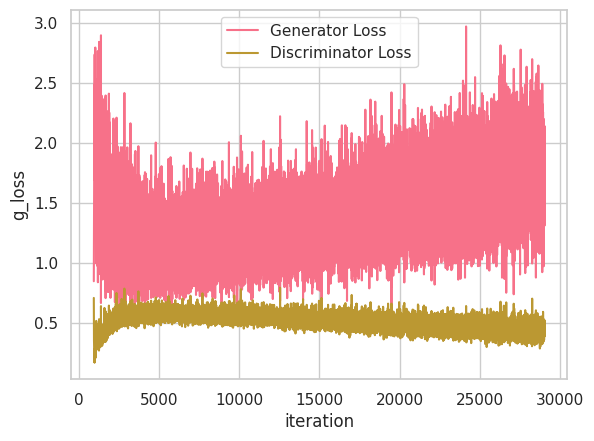

In [27]:
ax = sns.lineplot(data=history,x="iteration",y="g_loss",label="Generator Loss")
sns.lineplot(data=history,x="iteration",y="d_loss",label="Discriminator Loss",ax=ax)

In [28]:
def generate_gif(
    images : list[Tensor], 
    nrows : int,
    ncols : int,
    filename : str
) -> None:
    
    images = torch.stack(images,dim=0)
    images = images[:,:nrows*ncols,:,:]
    images = images.reshape(-1,32,32)
    images = F.pad(images, (4,4,4,4), value=1.0)
    images = images.reshape(-1,ncols,nrows,40,40)
    images = images.permute(0,1,3,2,4)
    images = images.flatten(1,2)
    images = images.flatten(2,3)
    
    images = images.numpy()
    images = images * 255.0
    images = images.astype(np.uint8)
    images = list(images)
    
    imageio.mimsave('/kaggle/working/gif.gif', images)

In [29]:
generate_gif(images,4,4,'')

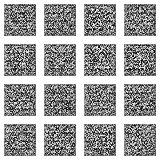

In [30]:
Image(open('/kaggle/working/gif.gif','rb').read())

<div id="gfd" >
    <h1 style="font-family:verdana;"> Generate fake data </h1>
</div>

In [31]:
labels = torch.randint(0,10,(N_ROWS * N_COLS,)).to(G.device)
fake_images = generator(labels).detach().cpu().numpy().squeeze()

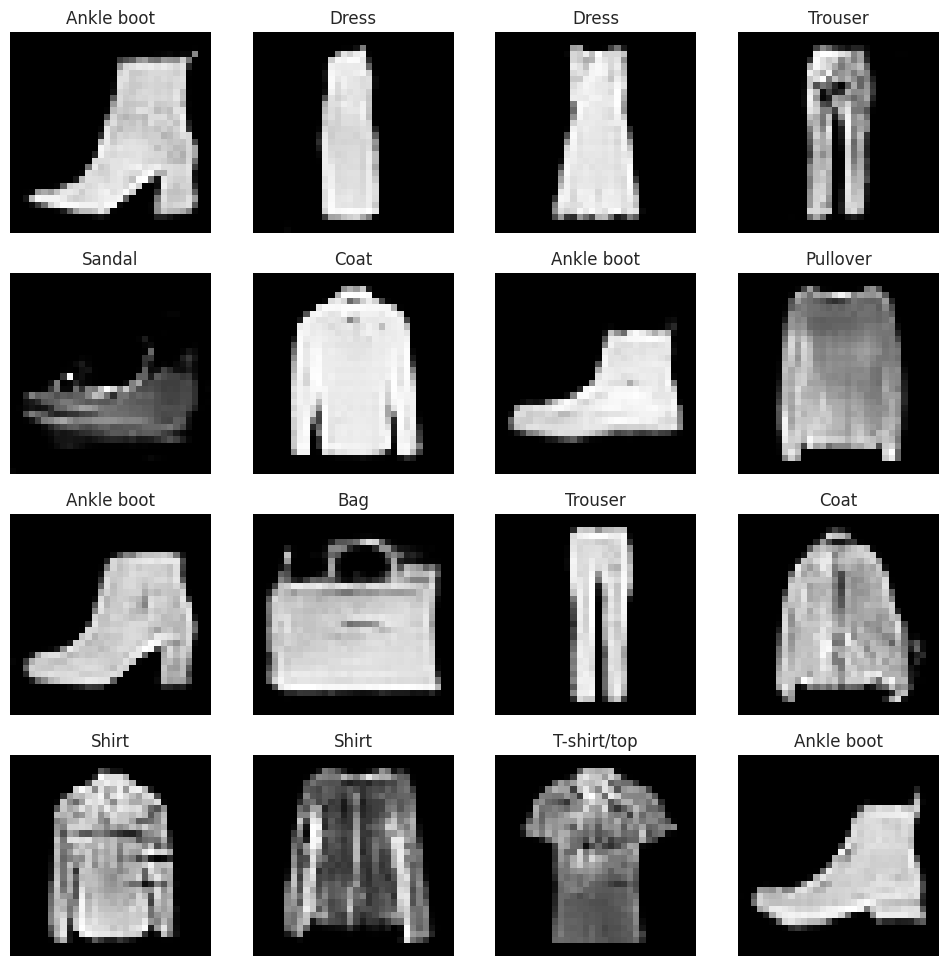

In [32]:
labels = classes[labels.cpu().numpy()]
display_images(fake_images, labels, N_ROWS, N_COLS)

<div id="thank_you" >
    <h1 style="font-family:verdana;"> Thank you :) </h1>
</div>